In [1]:
# prepare packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data', one_hot=True)

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
# our place holders
def model_inputs(x_dim, y_dim, z_dim):
    '''
    :param x_dim: real input size to discriminator. For MNIST 784
    :param y_dim: label input size to discriminator & generator. For MNIST 10
    :param z_dim: latent vector input size to generator. ex) 100
    '''
    inputs_x = tf.placeholder(tf.float32, [None, x_dim], name='inputs_x')
    inputs_y = tf.placeholder(tf.float32, [None, y_dim], name='inputs_y')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_x, inputs_y, inputs_z

In [4]:
# gennrator network structure
def generator(z, y, out_dim, n_hidden_units, reuse=False):
    '''
    :param z: placeholder of latent vector
    :param y: placeholder of labels
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # weight initializer
        w_init = tf.contrib.layers.xavier_initializer()
        
        # concatenate inputs
        concatenated_inputs = tf.concat(axis=1, values=[z, y])
        
        h1 = tf.layers.dense(concatenated_inputs, n_hidden_units, activation=tf.nn.relu, use_bias=True, kernel_initializer=w_init)
        
        # Logits and tanh (-1~1) output
        logits = tf.layers.dense(h1, out_dim, activation=None, use_bias=True, kernel_initializer=w_init)
        out = tf.tanh(logits)
        
        return out

In [5]:
def discriminator(x, y, n_hidden_units, reuse=False):
    '''
    :param x: placeholder of real or fake inputs
    :param y: placeholder of labels
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # weight initializer
        w_init = tf.contrib.layers.xavier_initializer()
        
        # concatenate inputs
        concatenated_inputs = tf.concat(axis=1, values=[x, y])
        
        h1 = tf.layers.dense(concatenated_inputs, n_hidden_units, activation=tf.nn.relu, use_bias=True, kernel_initializer=w_init)
        
        # Logits and sigmoid (0~1) output
        logits = tf.layers.dense(h1, 1, activation=None, use_bias=True, kernel_initializer=w_init)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def model_loss(inputs_x, inputs_y, inputs_z, output_dim):
    # Generator network here (g_model is the generator output)
    g_model = generator(z=inputs_z, y=inputs_y, out_dim=output_dim, n_hidden_units=g_hidden_size, reuse=False)
    
    # Disriminator network here
    d_model_real, d_logits_real = discriminator(x=inputs_x, y=inputs_y, n_hidden_units=d_hidden_size, reuse=False)
    d_model_fake, d_logits_fake = discriminator(x=g_model, y=inputs_y, n_hidden_units=d_hidden_size, reuse=True)
    
    # Calculate losses
    real_labels = tf.ones_like(d_logits_real) * (1 - smooth) # label smoothing
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels) )
    
    fake_labels = tf.zeros_like(d_logits_real)
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels) )
    
    d_loss = d_loss_real + d_loss_fake
    
    gen_labels = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=gen_labels) )
    
    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [8]:
# Size of input image to discriminator (28x28 MNIST images flattened)
x_size = 28 * 28
# Size of labels (classes)
y_size = 10
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128 # 256
d_hidden_size = 128 # 1024
# learning rate
learning_rate = 0.001
# adamoptimizer
beta1 = 0.5
# Label smoothing 
smooth = 0.0

In [9]:
# Build Network

# wipe out previous graphs and make us to start building new graph from here
tf.reset_default_graph()

# Create our input placeholders
input_x, input_y, input_z = model_inputs(x_dim=x_size, y_dim=y_size, z_dim=z_size)

# build loss functions
d_loss, g_loss = model_loss(inputs_x=input_x, inputs_y=input_y, inputs_z=input_z, output_dim=x_size)

# Optimizers
d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learning_rate, beta1=beta1)

In [10]:
def generate_with_consistent_style(sess, input_z, input_y, n_style=10):
    latent_z = np.random.uniform(-1, 1, size=(n_style, z_size))
    
    generated_samples = []
    for s, sample_z in enumerate(latent_z):
        sample_z = np.reshape(sample_z, [1, z_size])
        
        each_class_samples = []
        for c in range(y_size):
            sample_y = np.zeros(shape=[1, y_size])
            sample_y[:, c] = 1
            
            gen_samples = sess.run( 
                generator(z=input_z, y=input_y, out_dim=x_size, n_hidden_units=g_hidden_size, reuse=True),
                feed_dict={input_z: sample_z, input_y: sample_y})
            
            each_class_samples.append(gen_samples)
        generated_samples.append(each_class_samples)
    
    return generated_samples

In [12]:
# Training session
batch_size = 64
epochs = 30
samples = []
losses = []
save_sample_every = epochs // 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            x_, y_ = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            x_ = x_.reshape((batch_size, 784))
            x_ = x_*2 - 1
            
            # Sample random noise for G
            z_ = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={input_x: x_, input_y: y_, input_z: z_})
            _ = sess.run(g_opt, feed_dict={input_z: z_, input_y: y_, input_x: x_})
            
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_x: x_, input_y: y_, input_z: z_})
        train_loss_g = g_loss.eval({input_z: z_, input_y: y_})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        if e % save_sample_every == 0:
            # Sample from generator as we're training for viewing afterwards
            # sample each classes with same style
            samples_current_epoch = []
            for c in range(y_size):
                sample_z = np.random.uniform(-1, 1, size=(1, z_size))
                sample_y = np.zeros(shape=[1, y_size])
                sample_y[:, c] = 1
                gen_samples = sess.run( 
                    generator(z=input_z, y=input_y, out_dim=x_size, n_hidden_units=g_hidden_size, reuse=True),
                    feed_dict={input_z: sample_z, input_y: sample_y})
                
                samples_current_epoch.append(gen_samples)
            samples.append(samples_current_epoch)
        
    final_samples = generate_with_consistent_style(sess, input_z, input_y, n_style=10)

Epoch 1/30... Discriminator Loss: 1.4304... Generator Loss: 0.4304
Epoch 2/30... Discriminator Loss: 0.8713... Generator Loss: 1.5272
Epoch 3/30... Discriminator Loss: 0.7633... Generator Loss: 1.5124
Epoch 4/30... Discriminator Loss: 0.9119... Generator Loss: 1.2732
Epoch 5/30... Discriminator Loss: 1.1059... Generator Loss: 0.9318
Epoch 6/30... Discriminator Loss: 0.9053... Generator Loss: 1.2402
Epoch 7/30... Discriminator Loss: 1.0562... Generator Loss: 1.2293
Epoch 8/30... Discriminator Loss: 1.0578... Generator Loss: 1.1878
Epoch 9/30... Discriminator Loss: 1.0067... Generator Loss: 1.1984
Epoch 10/30... Discriminator Loss: 0.9755... Generator Loss: 0.9908
Epoch 11/30... Discriminator Loss: 0.9813... Generator Loss: 1.2296
Epoch 12/30... Discriminator Loss: 1.0303... Generator Loss: 1.0394
Epoch 13/30... Discriminator Loss: 1.0172... Generator Loss: 0.9748
Epoch 14/30... Discriminator Loss: 1.0309... Generator Loss: 1.1827
Epoch 15/30... Discriminator Loss: 1.1471... Generator Lo

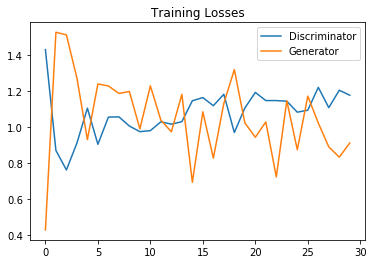

In [13]:
# display training loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [14]:
samples = np.array(samples)
final_samples = np.array(final_samples)
print('sample shape: ', samples.shape)
print('final_samples shape: ', final_samples.shape)

sample shape:  (10, 10, 1, 784)
final_samples shape:  (10, 10, 1, 784)


In [15]:
# generate generator samples
def view_samples(samples):
    n_epochs = samples.shape[0]
    n_classes = samples.shape[1]
    fig, axes = plt.subplots(figsize=(n_classes, n_epochs), nrows=n_epochs, ncols=n_classes, sharey=True, sharex=True)
    for samp, ax_row in zip(samples, axes):
        for single_class, ax in zip(samp, ax_row):
            ax.imshow(single_class.reshape((28,28)), cmap='Greys_r')
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    return fig, axes

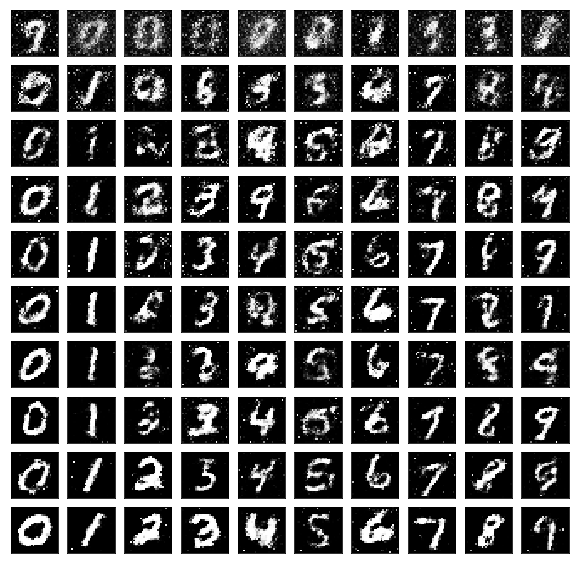

In [16]:
# view history of generated samples
_ = view_samples(samples)

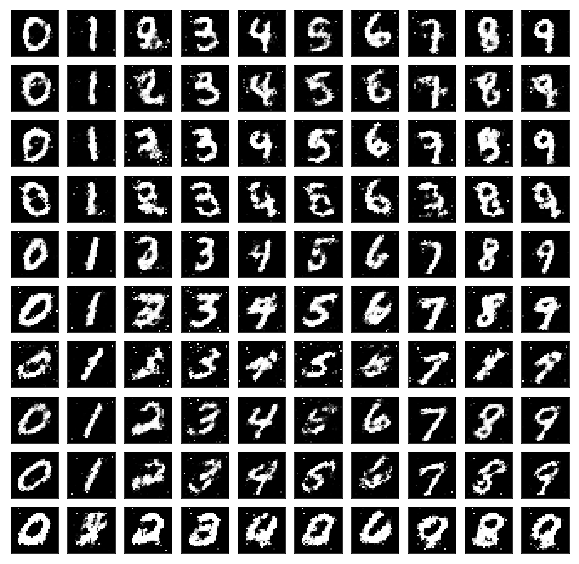

In [17]:
_ = view_samples(final_samples)